
*   Изучена архитектура модели DETR
*   Загрузка готовой модели и тестирования на своем изображении





In [2]:
import torch
from torch import nn
from torchvision.models import resnet50


class DETR(nn.Module):
    def __init__(
        self, num_classes, hidden_dim, nheads, num_encoder_layers, num_decoder_layers
    ):
        super().__init__()
        # Создаем уже готовую модель CNN
        self.backbone = nn.Sequential(*list(resnet50(pretrained=True).children())[:-2])
        # Уменьшаем размер изображения с помощью свертки
        self.conv = nn.Conv2d(2048, hidden_dim, 1)
        # Создаем модель трансформера
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers
        )
        # Определение класса объекта
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        # Определение ограничивающих рамок объекта
        self.linear_bbox = nn.Linear(hidden_dim, 4)
        # Определение запросов в декодере
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))
        # Создание набора чисел для эммбедингов
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

# Функция работы с входными данными
    def forward(self, inputs):
        x = self.backbone(inputs)
        h = self.conv(x)
        H, W = h.shape[-2:]
        pos = (
            torch.cat(
                [
                    self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
                    self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
                ],
                dim=-1,
            )
            .flatten(0, 1)
            .unsqueeze(1)
        )
        h = self.transformer(
            pos + h.flatten(2).permute(2, 0, 1), self.query_pos.unsqueeze(1)
        )
        return self.linear_class(h), self.linear_bbox(h).sigmoid()

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

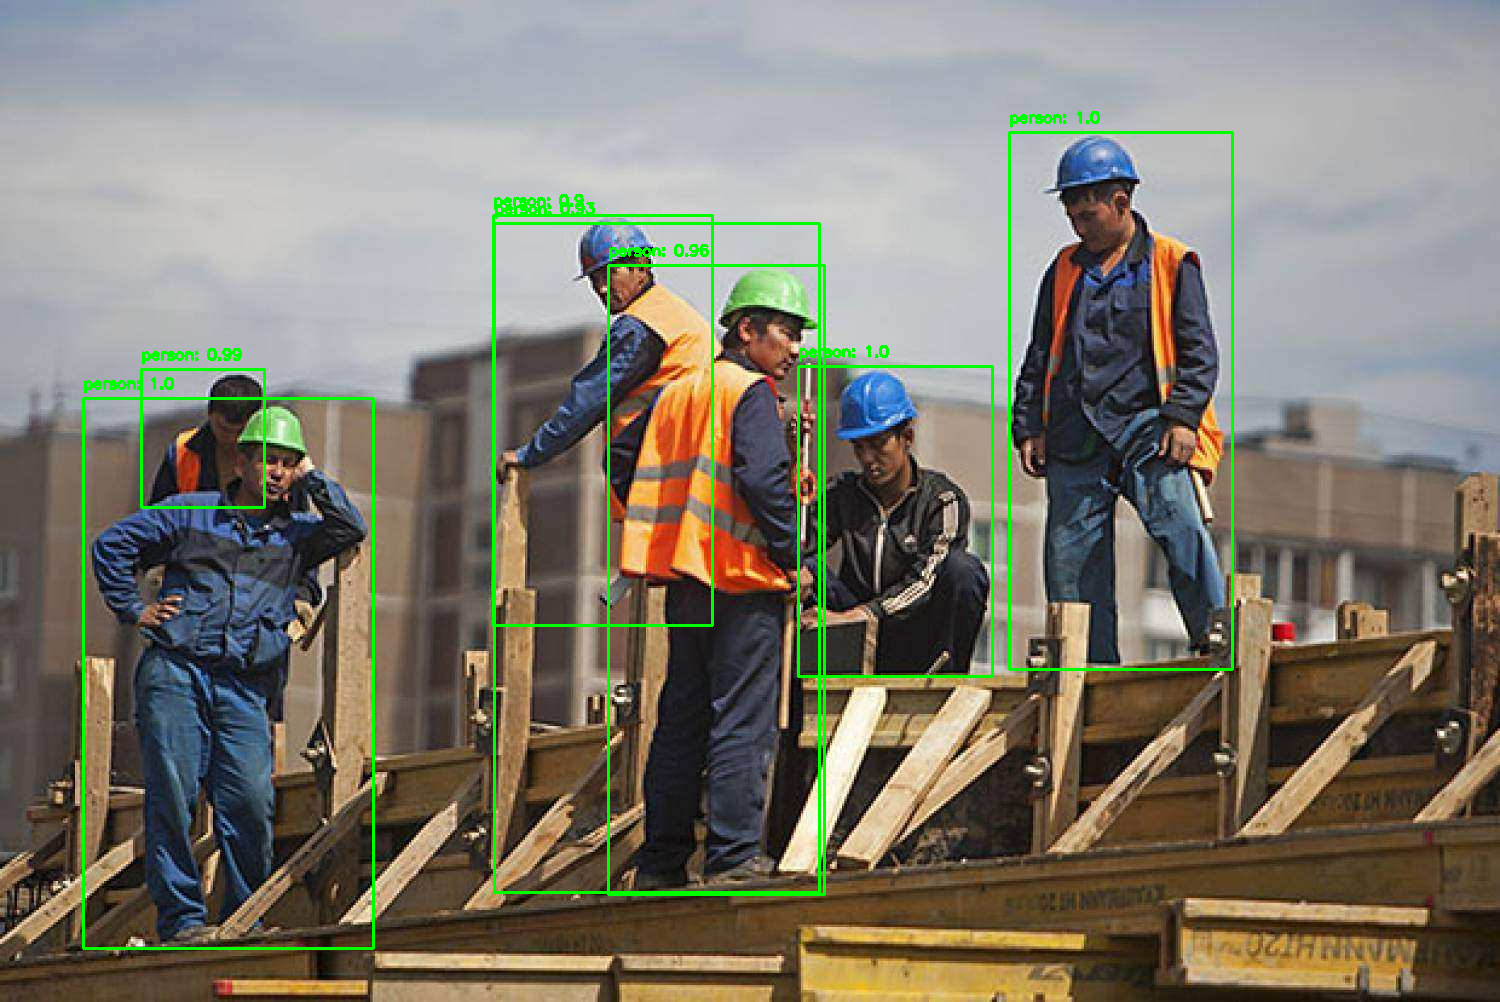

In [5]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


image = Image.open("helmet.jpg")


# initialize the model
processor = DetrImageProcessor.from_pretrained(
    "facebook/detr-resnet-101", revision="no_timm"
)
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-101", revision="no_timm"
)

# preprocess the inputs and infer
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# non max supression above 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(
    outputs, target_sizes=target_sizes, threshold=0.9
)[0]

image_np = np.array(image)
image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [int(i) for i in box.tolist()]
    image_np = cv2.rectangle(image_np, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)

    text = f"{model.config.id2label[label.item()]}: {round(score.item(), 2)}"
    image_np = cv2.putText(
        image_np,
        text,
        (box[0], box[1] - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 255, 0),
        2
    )

cv2_imshow(image_np)
cv2.waitKey(0)
cv2.destroyAllWindows()